# Linear Discriminant Analysis python tutorial
- 클래스 내의 분산은 최소화하고, 클래스 간의 분산(클래스별 사영된 평균 사이의 거리)을 최대화하는 게 목적
- 분리 가능한 기존의 데이터 차원을 더 낮은 차원의 부분 공간으로 정의
- 지도학습 기반의 차원 축소 방법론

### LDA의 장점
- 일반화된 eigenvalu system을 풀면 해를 얻을 수 있음
- Kernel trick을 통해 비선형 LDA로 확장 가능
- 분류, 차원 축소, 변수 중요도에 대한 해석에 사용될 수 있음

### LDA의 단점
- 독립변수에 대한 정규분포 가정이 만족되지 못하면 축소된 차원이 고차원을 잘 설명하지 못함
- 클래스별 공분산 구조가 서로 다른 경우를 반영하지 못함
- 가장 작은 그룹의 관측치 수가 설명변수의 개수보다 많아야 함
<br/><br/>

| PCA    | LDA                                    |
| ---------- | ---------------------------------------------- |
| unsupervised | supervised                 |
| 분포에 대한 가정은 없음   | 변수들이 분포가 정규분포임을 가정 |
| 전체 데이테셋의 분산을 최대화하는 방향으로 projection   | 클래스 간의 분리를 최대화하는 축을 나타내는 방향으로 projection |

### 데이터 설명 및 LDA tutorial 순서
- 데이터 설명
    - 자동차 데이터 (203개의 자동차에 대한 정보)
    - Link: https://www.kaggle.com/datasets/tr1gg3rtrash/cars-2022-dataset
- Tutorial 순서
    1. Numpy
    2. Pytorch
    3. sklearn

### 결과 해석
- 독립 변수 개수와 상관없이 각 클래스별 분리가 최대화되는 방향으로 차원이 축소된 것을 알 수 있다. 변수의 개수를 2개에서 5개로 늘렸을 때, 차원 축소가 더 잘 된 것으로 보인다.

----

In [223]:
"""라이브러리 호출"""
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [207]:
"""데이터 로드 및 전처리"""
## 데이터 불러오기
df = pd.read_csv('data/CARS_1.csv', index_col=0)
print(df.shape)
df.head()

(203, 15)


,reviews_count,fuel_type,engine_displacement,no_cylinder,seating_capacity,transmission_type,fuel_tank_capacity,body_type,rating,starting_price,ending_price,max_torque_nm,max_torque_rpm,max_power_bhp,max_power_rp
car_name,,,,,,,,,,,,,,,
Maruti Alto K10,51,Petrol,998,3,5.0,Automatic,27.0,Hatchback,4.5,399000,583000,89.0,3500,65.71,5500
Maruti Brezza,86,Petrol,1462,4,5.0,Automatic,48.0,SUV,4.5,799000,1396000,136.8,4400,101.65,6000
Mahindra Thar,242,Diesel,2184,4,4.0,Automatic,57.0,SUV,4.5,1353000,1603000,300.0,2800,130.00,3750
Mahindra XUV700,313,Diesel,2198,4,7.0,Automatic,60.0,SUV,4.5,1318000,2458000,450.0,2800,182.38,3500
Mahindra Scorpio-N,107,Diesel,2198,4,7.0,Automatic,57.0,SUV,4.5,1199000,2390000,400.0,2750,172.45,3500


In [208]:
## 3개의 연속형 변수 추출
    # LDA는 독립변수가 모두 등간 척도 or 비율 척도를 따라야 한다.
for col in df.columns.difference(['fuel_type']):
    if df[f'{col}'].dtypes=='O':
        df.drop(f'{col}', axis=1, inplace=True)

In [209]:
## 종속 변수 변환
df['fuel_type'].replace({'Petrol':0,
'Diesel':1,
'Electric':2,
'CNG':2}, inplace=True)

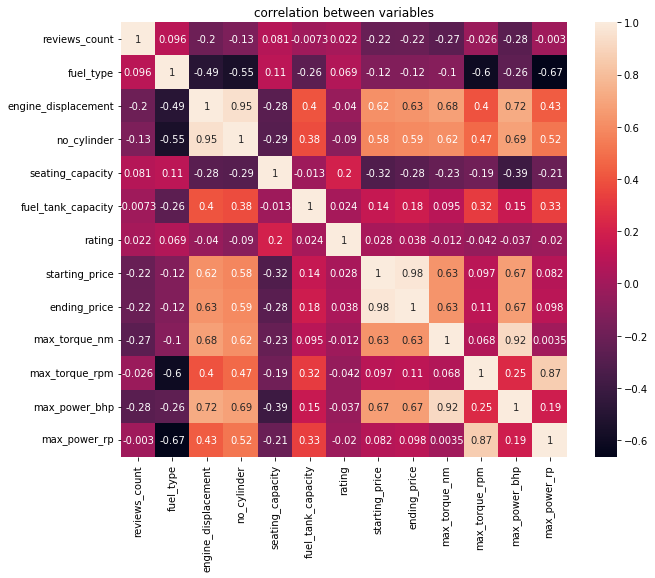

In [210]:
## 상관관계 확인
    # LDA를 위해서는 독립변수 간에는 상관관계가 낮아야 한다.
corr_ = df.corr()
plt.figure(figsize = (10,8))
ax = sns.heatmap(corr_, annot=True)
plt.title('correlation between variables')
plt.show()

In [211]:
## 독립변수들 간의 상관관계를 고려해서 4개의 변수 선택
df = df[['max_power_rp','no_cylinder','engine_displacement','fuel_tank_capacity','starting_price','fuel_type']]
df.head()

,max_power_rp,no_cylinder,engine_displacement,fuel_tank_capacity,starting_price,fuel_type
car_name,,,,,,
Maruti Alto K10,5500,3,998,27.0,399000,0
Maruti Brezza,6000,4,1462,48.0,799000,0
Mahindra Thar,3750,4,2184,57.0,1353000,1
Mahindra XUV700,3500,4,2198,60.0,1318000,1
Mahindra Scorpio-N,3500,4,2198,57.0,1199000,1


-------

## Numpy를 활용한 LDA
- 3개의 class와 2개의 변수 사용
- 3개의 class와 5개의 변수 사용

In [212]:
"""class 정의"""
class LDA:
    def __init__(self):
        pass

    def fit(self, X, y):
        target_classes = np.unique(y)

        mean_vectors = []
        
        ## 클래스별 평균 계산
        for cls in target_classes: 
            mean_vectors.append(np.mean(X[y == cls], axis=0))
        ## 클래스가 2개 이하인 경우 클래스 간의 분산 행렬 계산
        if len(target_classes) < 3:
            mu1_mu2 = (mean_vectors[0] - mean_vectors[1]).reshape(1, X.shape[1])
            B = np.dot(mu1_mu2.T, mu1_mu2)
        ## 클래스가 3개 이상인 경우 클래스 간 분산 행렬 계산
        else:
            data_mean = np.mean(X, axis=0).reshape(1, X.shape[1])
            B = np.zeros((X.shape[1], X.shape[1]))
            for i, mean_vec in enumerate(mean_vectors):
                n = X[y == i].shape[0]
                mean_vec = mean_vec.reshape(1, X.shape[1])
                mu1_mu2 = mean_vec - data_mean
                B += n * np.dot(mu1_mu2.T, mu1_mu2) 

        ## 클래스별 분산행렬 구하기
        In_SM = []
        for cls, mean in enumerate(mean_vectors):
            Si = np.zeros((X.shape[1], X.shape[1]))
            for row in X[y == cls]:
                t = (row - mean).reshape(1, X.shape[1])
                Si += np.dot(t.T, t)
            In_SM.append(Si)

        ## 클래스 내 분산행렬 구하기
        S = np.zeros((X.shape[1], X.shape[1]))
        for s_i in In_SM:
            S += s_i

        ## "클래스 내의 분산 합(S)의 역행렬"과 "클래스 간의 분산 행렬(BS)" 곱하기
        S_inv = np.linalg.inv(S)
        S_inv_B = S_inv.dot(B)

        eig_vals, eig_vecs = np.linalg.eig(S_inv_B) # np.linalg.eig()를 사용하여 고유값과 고유벡터 계산

        idx = eig_vals.argsort()[::-1] # 오름차순 정렬

        eig_vals = eig_vals[idx] # 고유값 계산
        eig_vecs = eig_vecs[:, idx] # 고유벡터 계산

        return eig_vecs

#### 1) 3개의 클래스와 2개의 변수에 대한 LDA
- `class 분해`하여 하나씩 진행

In [213]:
"""LDA"""
X = df[['max_power_rp','no_cylinder']].values
y = df['fuel_type'].astype(int).values

## 정규화
X = StandardScaler().fit_transform(X)

## class 설정
target_classes = np.unique(y)

In [161]:
## class별 평균값
vector_mean = []
for class_name in target_classes:
    vector_mean.append(np.mean(X[y == class_name], axis=0))


## 클래스 간의 분산 행렬(BS) 계산
data_mean = np.mean(X, axis=0).reshape(1, X.shape[1])
BS = np.zeros((X.shape[1], X.shape[1]))

for i, mean_vec in enumerate(vector_mean):
	n = X[y == i].shape[0]
	mean_vec = mean_vec.reshape(1, X.shape[1])
	mu1_mu2 = mean_vec - data_mean
 
	BS += n * np.dot(mu1_mu2.T, mu1_mu2)

In [162]:
## 클래스별 분산 행렬(SM) 계산
In_SM = []
 
for cls, mean in enumerate(vector_mean):
	Si = np.zeros((X.shape[1], X.shape[1]))
	for row in X[y == cls]:
		t = (row - mean).reshape(1, X.shape[1])
		Si += np.dot(t.T, t)
	In_SM.append(Si)

In [163]:
## 클래스 내의 분산 함 구하기
S = np.zeros((X.shape[1], X.shape[1]))
for s_i in In_SM:
	S += s_i

In [164]:
## "클래스 내의 분산 합(S)의 역행렬"과 "클래스 간의 분산 행렬(BS)" 곱하기
S_inv = np.linalg.inv(S)
 
S_inv_B = S_inv.dot(BS)
 
eigenvalues, eigenvectors = np.linalg.eig(S_inv_B)

In [165]:
## 고유값이 큰 순서로 정렬해서 고유벡터 구하기
idx = eigenvalues.argsort()[::-1]
 
eigenvalues = eigenvalues[idx] # Not needed
eigenvectors = eigenvectors[:, idx]
eigenvectors

array([[ 0.86328007, -0.64701341],
       [ 0.50472519,  0.76247862]])

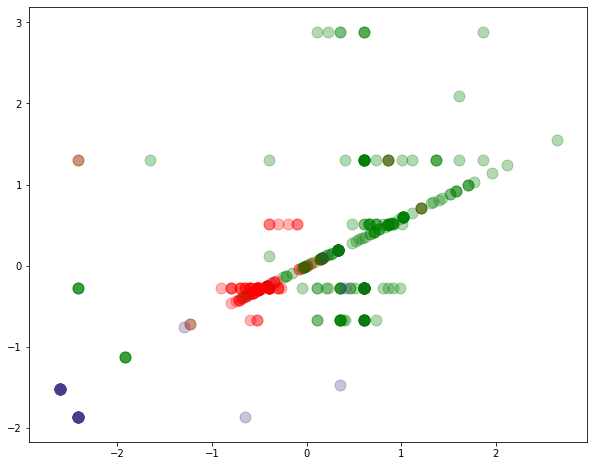

In [170]:
## 차원 축소 및 시각화 
    # 위에서 찾은 고유벡터와 원행렬을 곱하여 차원 축소 진행
W = eig_vecs[:, :1]

colors = ['green', 'red', 'darkslateblue']
fig, ax = plt.subplots(figsize=(10, 8))
for point, pred in zip(X, y):
    ax.scatter(point[0], point[1], color=colors[pred], alpha=0.3, s=120)
    proj = (np.dot(point, W) * W) / np.dot(W.T, W)
 
    ax.scatter(proj[0], proj[1], color=colors[pred], alpha=0.3, s=120)
 
plt.show()

#### 2) 3개의 클래스와 5개의 변수에 대한 LDA
- 위에서 정의한 `클래스 그대로 사용`

In [214]:
cols = ['max_power_rp','no_cylinder','engine_displacement','fuel_tank_capacity','starting_price']
X = df[cols].values
y = df['fuel_type'].astype(int).values
print(X.shape)

(203, 5)


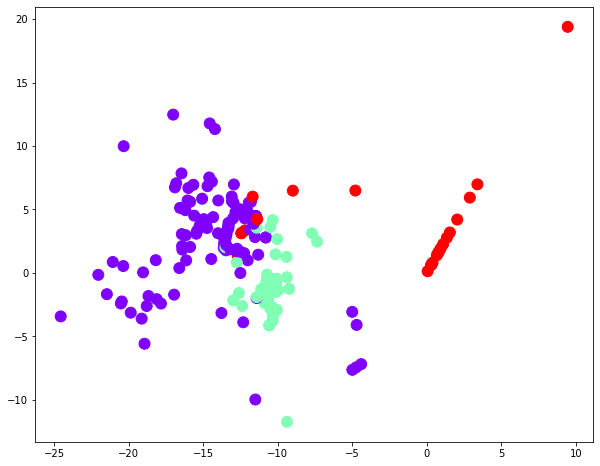

In [215]:
"""LDA 적용"""
lda = LDA() # 클래스 적용
eig_vecs = lda.fit(X, y)
ceta_ = eig_vecs[:, :2]

## 고유벡터와 원행렬 곱셈
transformed = X.dot(ceta_)

plt.figure(figsize = (10,8))
plt.scatter(transformed[:, 0], transformed[:, 1], c=y, cmap='rainbow', s=120)
plt.show()

-----

## pytorch를 활용한 LDA
- 위의 넘파이 class를 그대로 파이토치로 바꾼 것이다.
- 두 개의 클래스를 가진 데이터셋에 활용이 가능하다. </br></br>
Reference link: https://github.com/juliusbierk/torchlda

In [224]:
def LinearDiscriminatAnalysis_pytorch(x1, x2, device="cpu"):
    # Gradient 업데이트는 없어야 한다.
    with torch.no_grad():
        x1 = torch.tensor(x1, device=device, dtype=torch.float)
        x2 = torch.tensor(x2, device=device, dtype=torch.float)

        m1 = torch.mean(x1, dim=0)
        m2 = torch.mean(x2, dim=0)
        m = (len(x1) * m1 + len(x2) * m2) / (len(x1) + len(x2))

        d1 = x1 - m1[None, :]
        scatter1 = d1.t() @ d1
        d2 = x2 - m2[None, :]
        scatter2 = d2.t() @ d2
        within_class_scatter = scatter1 + scatter2 # 클래스 내의 분산 합치기 (S)

        d1 = m1 - m[None, :]
        scatter1 = len(x1) * (d1.t() @ d1)
        d2 = m2 - m[None, :]
        scatter2 = len(x2) * (d2.t() @ d2)
        between_class_scatter = scatter1 + scatter2 # 클래스 간의 분산 BS

        p = torch.pinverse(within_class_scatter) @ between_class_scatter
        eigenvalues, eigenvectors = torch.eig(p, eigenvectors=True) # torch.eig()를 활용한 고유값과 고유벡터 계산
        idx = torch.argsort(eigenvalues[:, 0], descending=True) # 오름차순 정렬을 위한 indexing
        eigenvalues = eigenvalues[idx, 0] # 고유값 계산
        eigenvectors = eigenvectors[idx, :] # 고유벡터 계산

        return eigenvectors[0, :].cpu().numpy()

In [238]:
## 5개의 변수를 사용
cols = ['max_power_rp','no_cylinder','engine_displacement','fuel_tank_capacity','starting_price']
X= df2.loc[df2['fuel_type'].isin([0,1]),['max_power_rp','no_cylinder','engine_displacement','fuel_tank_capacity','starting_price']].reset_index(drop=True)

## 두 클래스 각각 분리
x1 = df2[df2['fuel_type']==0].values
x2 = df2[df2['fuel_type']==1].values
print(x1.shape)

(125, 6)


In [239]:
## 고유벡터 계산
eigen_vector_torch = LinearDiscriminatAnalysis_pytorch(x1, x2)
eigen_vector_torch

array([ 1.2158638e-02, -1.2920402e-03, -6.1535725e-04,  3.6504379e-04,
        1.5446583e-05, -1.0787385e-04], dtype=float32)

------

## Sklearn을 활용한 LDA
- 단순 라이브러리를 활용하는 방법
- Numpy의 마지막 결과와 비슷한 것을 확인할 수 있다.

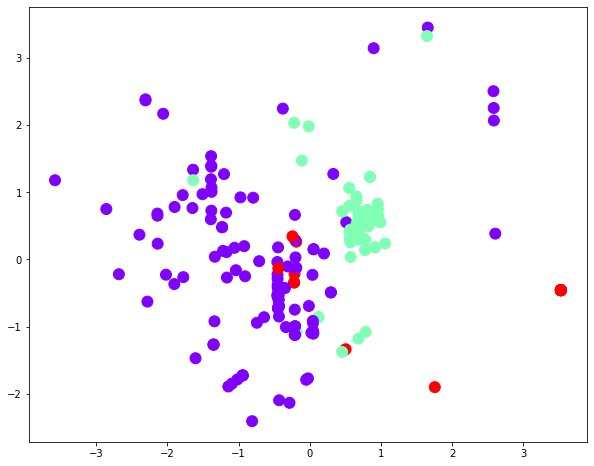

In [204]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(X, y)
transformed = clf.transform(X)

plt.figure(figsize = (10,8))
plt.scatter(transformed[:, 0], transformed[:, 1], c=y, cmap='rainbow', s=120)
plt.show()